# Imports

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os
import glob
import zipfile

import cv2
from PIL import Image
import albumentations as A

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.python.ops.math_ops import reduce_prod


AUTOTUNE = tf.data.experimental.AUTOTUNE


# Checking GPU

In [21]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


2.9.2
Num GPUs Available:  1


# Setting seeds

In [22]:
seed = 42


def seed_everything(seed=seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


seed_everything()


# Downloading dataset

In [ ]:
# !kaggle datasets download --force -d jessicali9530/celeba-dataset

In [ ]:
# dataset = zipfile.ZipFile("celeba-dataset.zip")
# dataset.extractall("dataset")


# Paths

In [23]:
path_image_dataset = "dataset/img_align_celeba/"
path_csv = "dataset/list_landmarks_align_celeba.csv"
img_files = glob.glob(f"{path_image_dataset}/*/*")


# Hyperparameters and constants

In [24]:
first_image = cv2.imread(img_files[0])
default_height, default_width = first_image.shape[:2]
default_height, default_width


(218, 178)

In [25]:
target_width = 100
target_height = 100
IMG_SIZE = (target_width, target_height)
BATCH_SIZE = 256
EPOCHS = 100


# EDA

In [26]:
landmarks = pd.read_csv(path_csv)
landmarks.sample(3)


image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  \
93241   093242.jpg         70        108         105         112      98   
121413  121414.jpg         69        111         108         112      89   
10624   010625.jpg         70        111         108         111      92   

        nose_y  leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
93241      127           77          153           104           154  
121413     129           74          152           104           152  
10624      141           73          152           103           153

In [29]:
landmarks_lips = landmarks.drop(
    columns=[
        "lefteye_x",
        "lefteye_y",
        "righteye_x",
        "righteye_y",
        "nose_x",
        "nose_y",
        "image_id",
    ],
)
landmarks_lips = landmarks_lips.rename(
    {
        "leftmouth_y": "y_min",
        "leftmouth_x": "x_min",
        "rightmouth_y": "y_max",
        "rightmouth_x": "x_max",
    },
    axis=1,
)
landmarks_lips.sample(3)


x_min  y_min  x_max  y_max
53130      72    153    100    151
165221     70    149    107    152
34427      72    153    105    154

## Images with bounding boxes

In [30]:
def view_image_from_file(file_names, xy):
    fig = plt.figure(figsize=(22, 22))
    number_of_images = len(file_names)
    for i, file in enumerate(file_names):
        img = Image.open(img_files[file])
        ax = fig.add_subplot(number_of_images // 2, 3, i + 1, xticks=[], yticks=[])
        img = cv2.rectangle(
            np.asarray(img), (xy[i][0], xy[i][1]), (xy[i][2], xy[i][3]), (0, 255, 0), 1
        )
        ax.imshow(np.array(img, np.int32))


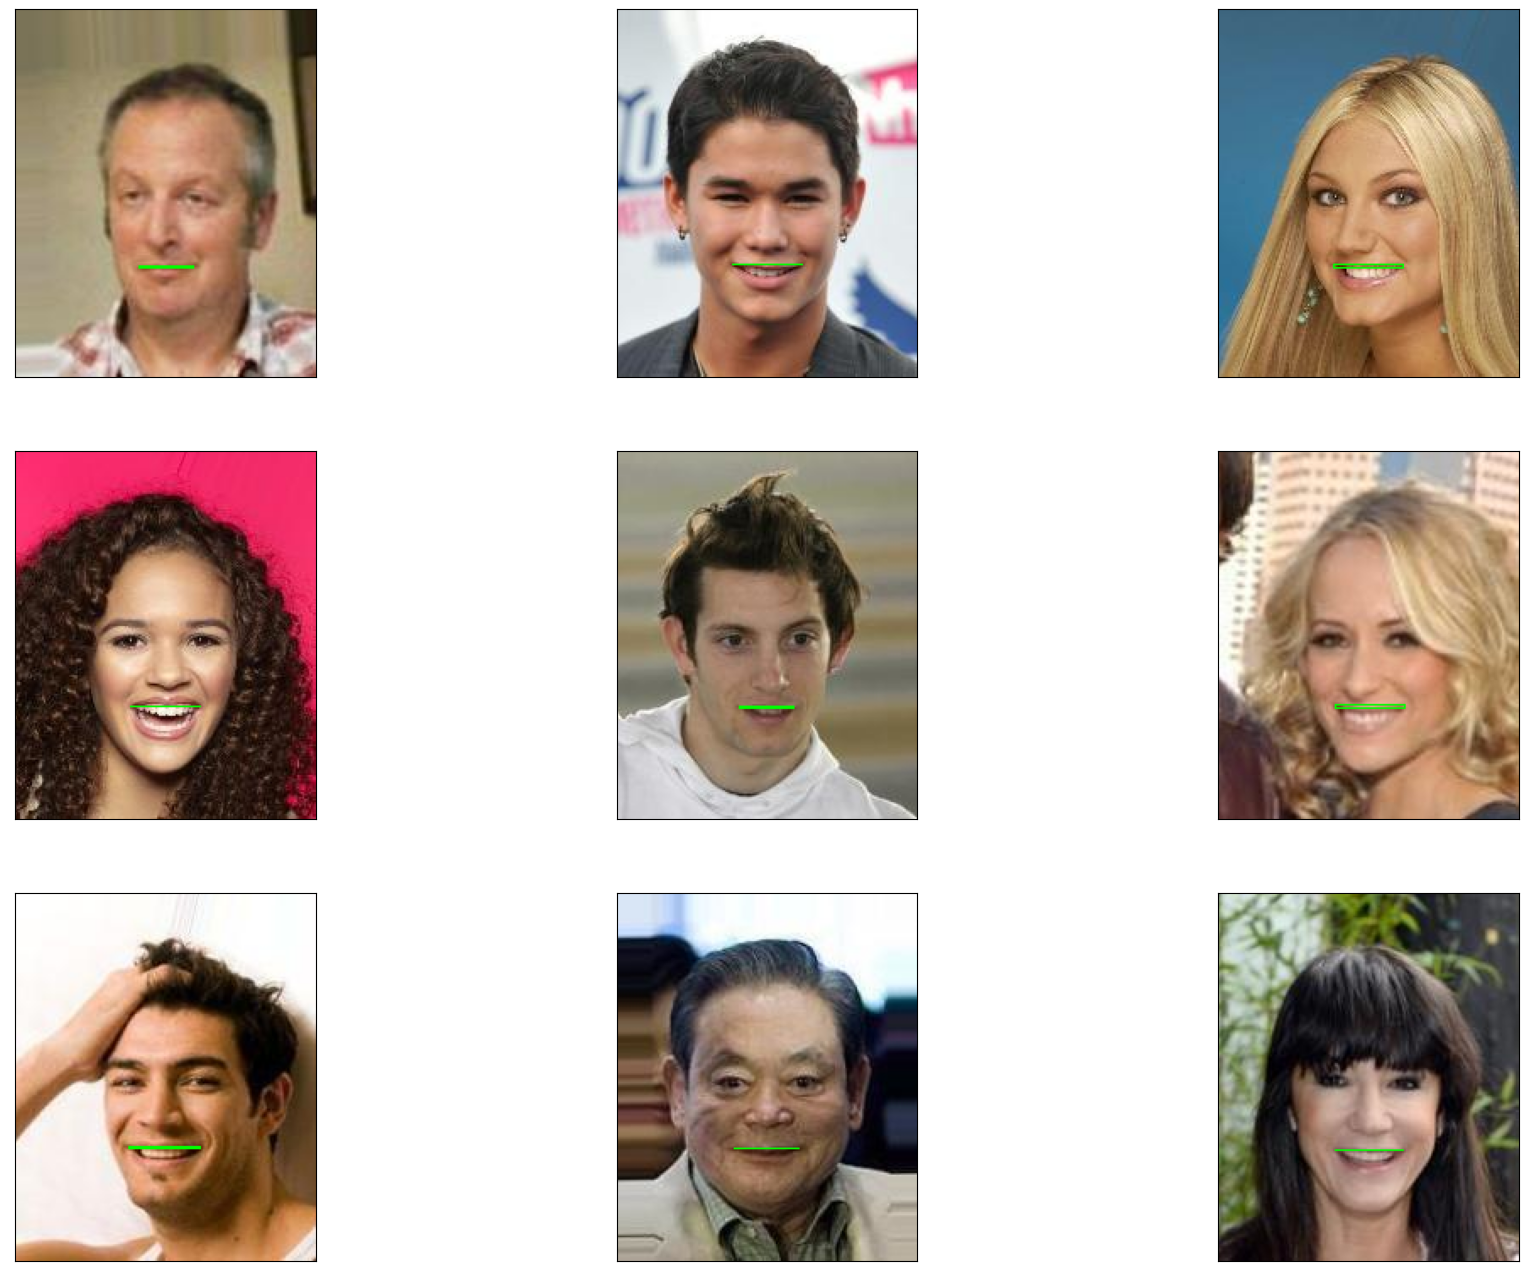

In [31]:
example_num_start = 6000
example_num_end = 6009
view_image_from_file(
    file_names=landmarks_lips.index[example_num_start:example_num_end],
    xy=landmarks_lips.values[example_num_start:example_num_end],
)


### Boundig boxes have misleading coordinates. Let's try to fix them.

In [32]:
landmarks_lips.loc[landmarks_lips["y_min"] >= landmarks_lips["y_max"]]


x_min  y_min  x_max  y_max
3          71    155    101    151
5          74    154    102    153
6          72    152    104    152
7          73    155    104    153
8          66    152    109    150
...       ...    ...    ...    ...
202589     73    152    104    152
202590     67    152    110    151
202593     74    153    103    151
202595     66    150    110    150
202597     71    153    106    151

[122548 rows x 4 columns]

In [33]:
landmarks_lips.loc[landmarks_lips["x_min"] >= landmarks_lips["x_max"]]


Empty DataFrame
Columns: [x_min, y_min, x_max, y_max]
Index: []

In [34]:
BIAS = 10
landmarks_lips["y_min"] = landmarks["leftmouth_y"].add(-BIAS)
landmarks_lips["y_max"] = landmarks["rightmouth_y"].add(+BIAS)
landmarks_lips.head()


x_min  y_min  x_max  y_max
0     73    142    108    164
1     70    141    108    163
2     74    146     98    168
3     71    145    101    161
4     71    137    104    160

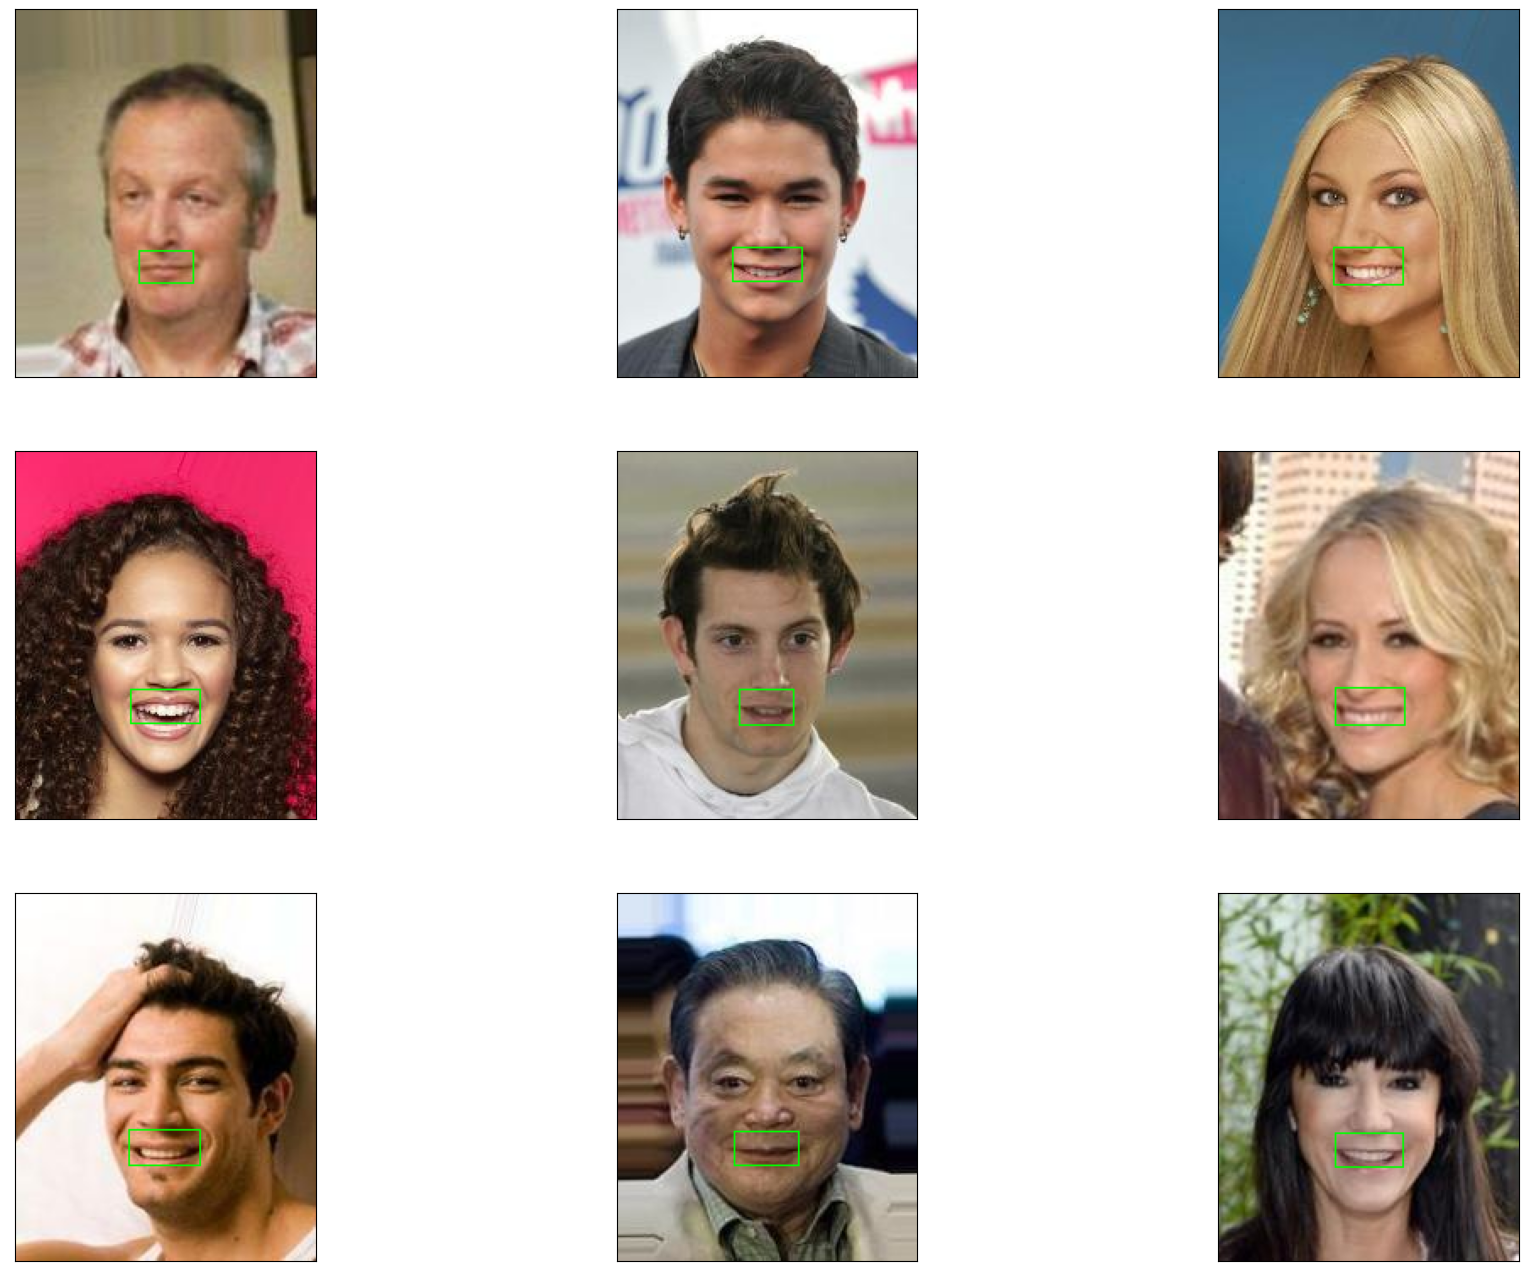

In [35]:
view_image_from_file(
    file_names=landmarks_lips.index[example_num_start:example_num_end],
    xy=landmarks_lips.values[example_num_start:example_num_end],
)


In [36]:
# We don't want values to be equal or min values to be higher than max values.
incorrect_values = landmarks_lips.loc[
    (landmarks_lips["y_min"] >= landmarks_lips["y_max"])
    | (landmarks_lips["x_min"] >= landmarks_lips["x_max"])
]
incorrect_values


x_min  y_min  x_max  y_max
24978      76    150     94    150
145109     64    159    104    153

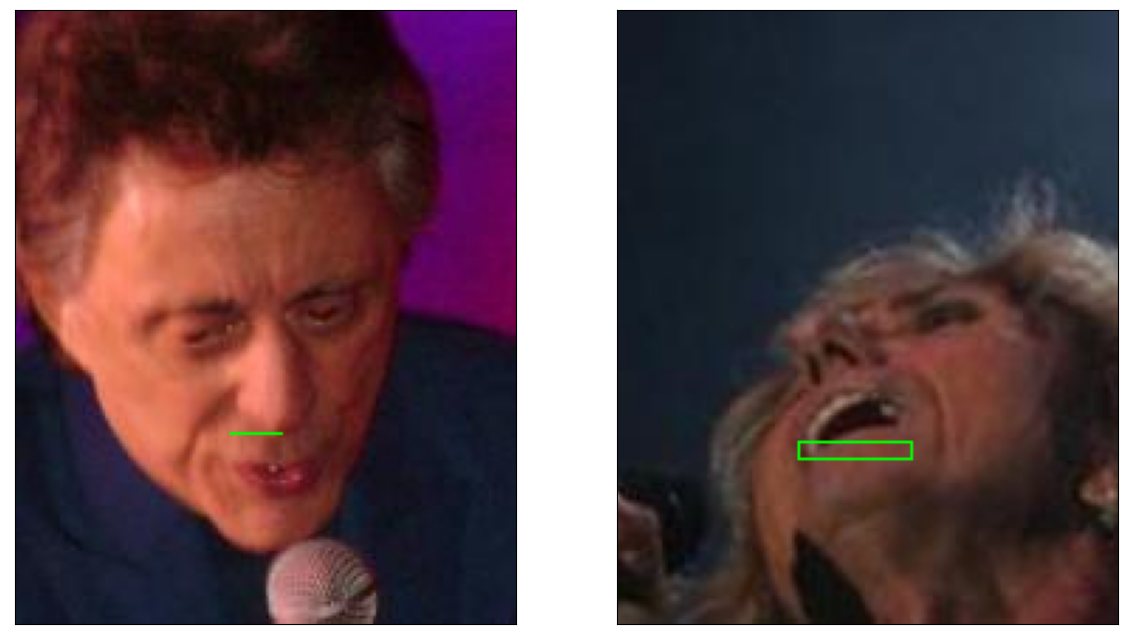

In [37]:
view_image_from_file(file_names=incorrect_values.index, xy=incorrect_values.values)


### Since there are only 2 images with wrong coordinates, we can try to fix them manually.

I made some improvements by trial and error. ;)


In [38]:
incorrect_values.iloc[0]["x_max"] = incorrect_values.iloc[0]["x_max"] + (15)
incorrect_values.iloc[0]["y_max"] = incorrect_values.iloc[0]["y_max"] + (20)
incorrect_values.iloc[0]["y_min"] = incorrect_values.iloc[0]["y_min"] + (5)

incorrect_values.iloc[1]["y_min"] = incorrect_values.iloc[1]["y_min"] - (30)
incorrect_values.iloc[1]["y_max"] = incorrect_values.iloc[1]["y_max"] + (10)
incorrect_values


x_min  y_min  x_max  y_max
24978      76    155    109    170
145109     64    129    104    163

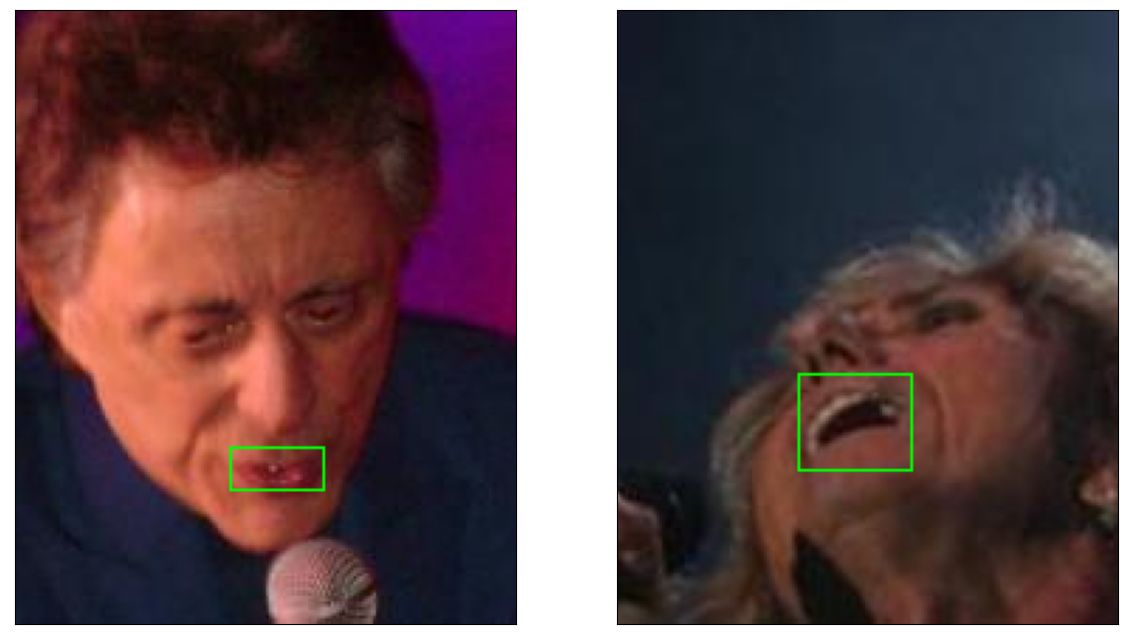

In [39]:
view_image_from_file(file_names=incorrect_values.index, xy=incorrect_values.values)


### Seems pretty good so we can apply the same operations on the right DataFrame.

In [40]:
landmarks_lips.iloc[incorrect_values.index[0]]["x_max"] = landmarks_lips.iloc[
    incorrect_values.index[0]
]["x_max"] + (15)
landmarks_lips.iloc[incorrect_values.index[0]]["y_max"] = landmarks_lips.iloc[
    incorrect_values.index[0]
]["y_max"] + (20)
landmarks_lips.iloc[incorrect_values.index[0]]["y_min"] = landmarks_lips.iloc[
    incorrect_values.index[0]
]["y_min"] + (5)

landmarks_lips["y_min"].iloc[incorrect_values.index[1]] = landmarks_lips["y_min"].iloc[
    incorrect_values.index[1]
] - (30)
landmarks_lips["y_max"].iloc[incorrect_values.index[1]] = landmarks_lips["y_max"].iloc[
    incorrect_values.index[1]
] + (10)


In [41]:
incorrect_values = landmarks_lips.loc[
    landmarks_lips["y_min"] >= landmarks_lips["y_max"]
]
incorrect_values


Empty DataFrame
Columns: [x_min, y_min, x_max, y_max]
Index: []

### Let's do last sanity check. 24978, 145109 are IDs of our incorrect images.

In [42]:
sanity_check = landmarks_lips.iloc[[24978, 145109], :]


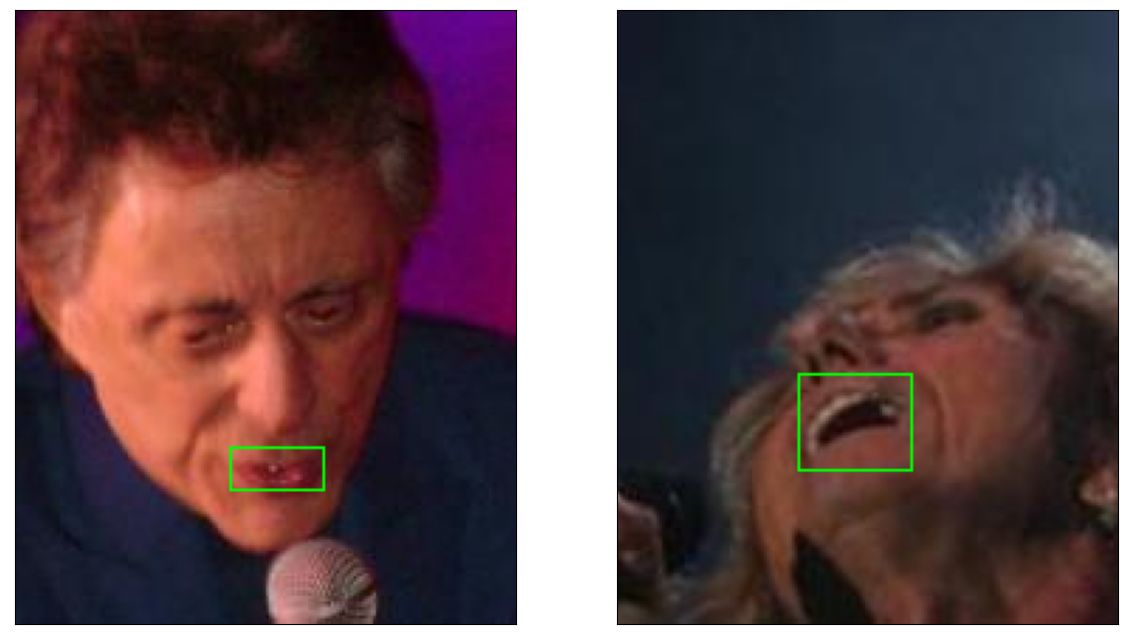

In [43]:
view_image_from_file(file_names=sanity_check.index, xy=sanity_check.values)


In [44]:
landmarks_lips.loc[landmarks_lips["y_min"] >= landmarks_lips["y_max"]]


Empty DataFrame
Columns: [x_min, y_min, x_max, y_max]
Index: []

In [45]:
landmarks_lips


x_min  y_min  x_max  y_max
0          73    142    108    164
1          70    141    108    163
2          74    146     98    168
3          71    145    101    161
4          71    137    104    160
...       ...    ...    ...    ...
202594     73    141    104    163
202595     66    140    110    160
202596     68    141    109    163
202597     71    143    106    161
202598     75    140    103    162

[202599 rows x 4 columns]

# Normalizing coordinates to 0-1 range

In [47]:
landmarks_lips_normalized = landmarks_lips[["x_min", "x_max"]].div(default_width)
landmarks_lips_normalized[["y_min", "y_max"]] = landmarks_lips[["y_min", "y_max"]].div(
    default_height
)
landmarks_lips_normalized


x_min     x_max     y_min     y_max
0       0.410112  0.606742  0.651376  0.752294
1       0.393258  0.606742  0.646789  0.747706
2       0.415730  0.550562  0.669725  0.770642
3       0.398876  0.567416  0.665138  0.738532
4       0.398876  0.584270  0.628440  0.733945
...          ...       ...       ...       ...
202594  0.410112  0.584270  0.646789  0.747706
202595  0.370787  0.617978  0.642202  0.733945
202596  0.382022  0.612360  0.646789  0.747706
202597  0.398876  0.595506  0.655963  0.738532
202598  0.421348  0.578652  0.642202  0.743119

[202599 rows x 4 columns]

##  Reorganizing columns order 

In [48]:
cols = landmarks_lips_normalized.columns.tolist()
cols = [cols[0], cols[2], cols[1], cols[3]]
landmarks_lips_normalized = landmarks_lips_normalized[cols]


In [49]:
landmarks_lips_normalized


x_min     y_min     x_max     y_max
0       0.410112  0.651376  0.606742  0.752294
1       0.393258  0.646789  0.606742  0.747706
2       0.415730  0.669725  0.550562  0.770642
3       0.398876  0.665138  0.567416  0.738532
4       0.398876  0.628440  0.584270  0.733945
...          ...       ...       ...       ...
202594  0.410112  0.646789  0.584270  0.747706
202595  0.370787  0.642202  0.617978  0.733945
202596  0.382022  0.646789  0.612360  0.747706
202597  0.398876  0.655963  0.595506  0.738532
202598  0.421348  0.642202  0.578652  0.743119

[202599 rows x 4 columns]

In [50]:
landmarks_lips = landmarks_lips.values.tolist()
landmarks_lips_normalized = landmarks_lips_normalized.values.tolist()


# Loading images from directory

In [51]:
data = tf.keras.utils.image_dataset_from_directory(
    path_image_dataset,
    batch_size=None,
    image_size=IMG_SIZE,
    labels=landmarks_lips_normalized,
    shuffle=False,
)
print(data)


Found 202599 files belonging to 1 classes.
<PrefetchDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>


In [52]:
def view_image_from_dataset(ds, number_of_samples):
    fig = plt.figure(figsize=(22, 22))
    images = ds.take(number_of_samples)
    for i, file in enumerate(images):
        ax = fig.add_subplot(number_of_samples // 2, 3, i + 1, xticks=[], yticks=[])
        img = cv2.rectangle(
            np.asarray(file[0]),
            (int(file[1][0] * 100), int(file[1][1] * 100)),
            (int(file[1][2] * 100), int(file[1][3] * 100)),
            (0, 255, 0),
            1,
        )
        ax.set_title(
            f"boundig box:({int(file[1][0]*100)},{int(file[1][1]*100)})({int(file[1][2]*100)},{int(file[1][3]*100)})",
            fontsize=15,
        )
        ax.imshow(np.array(img, np.int32))


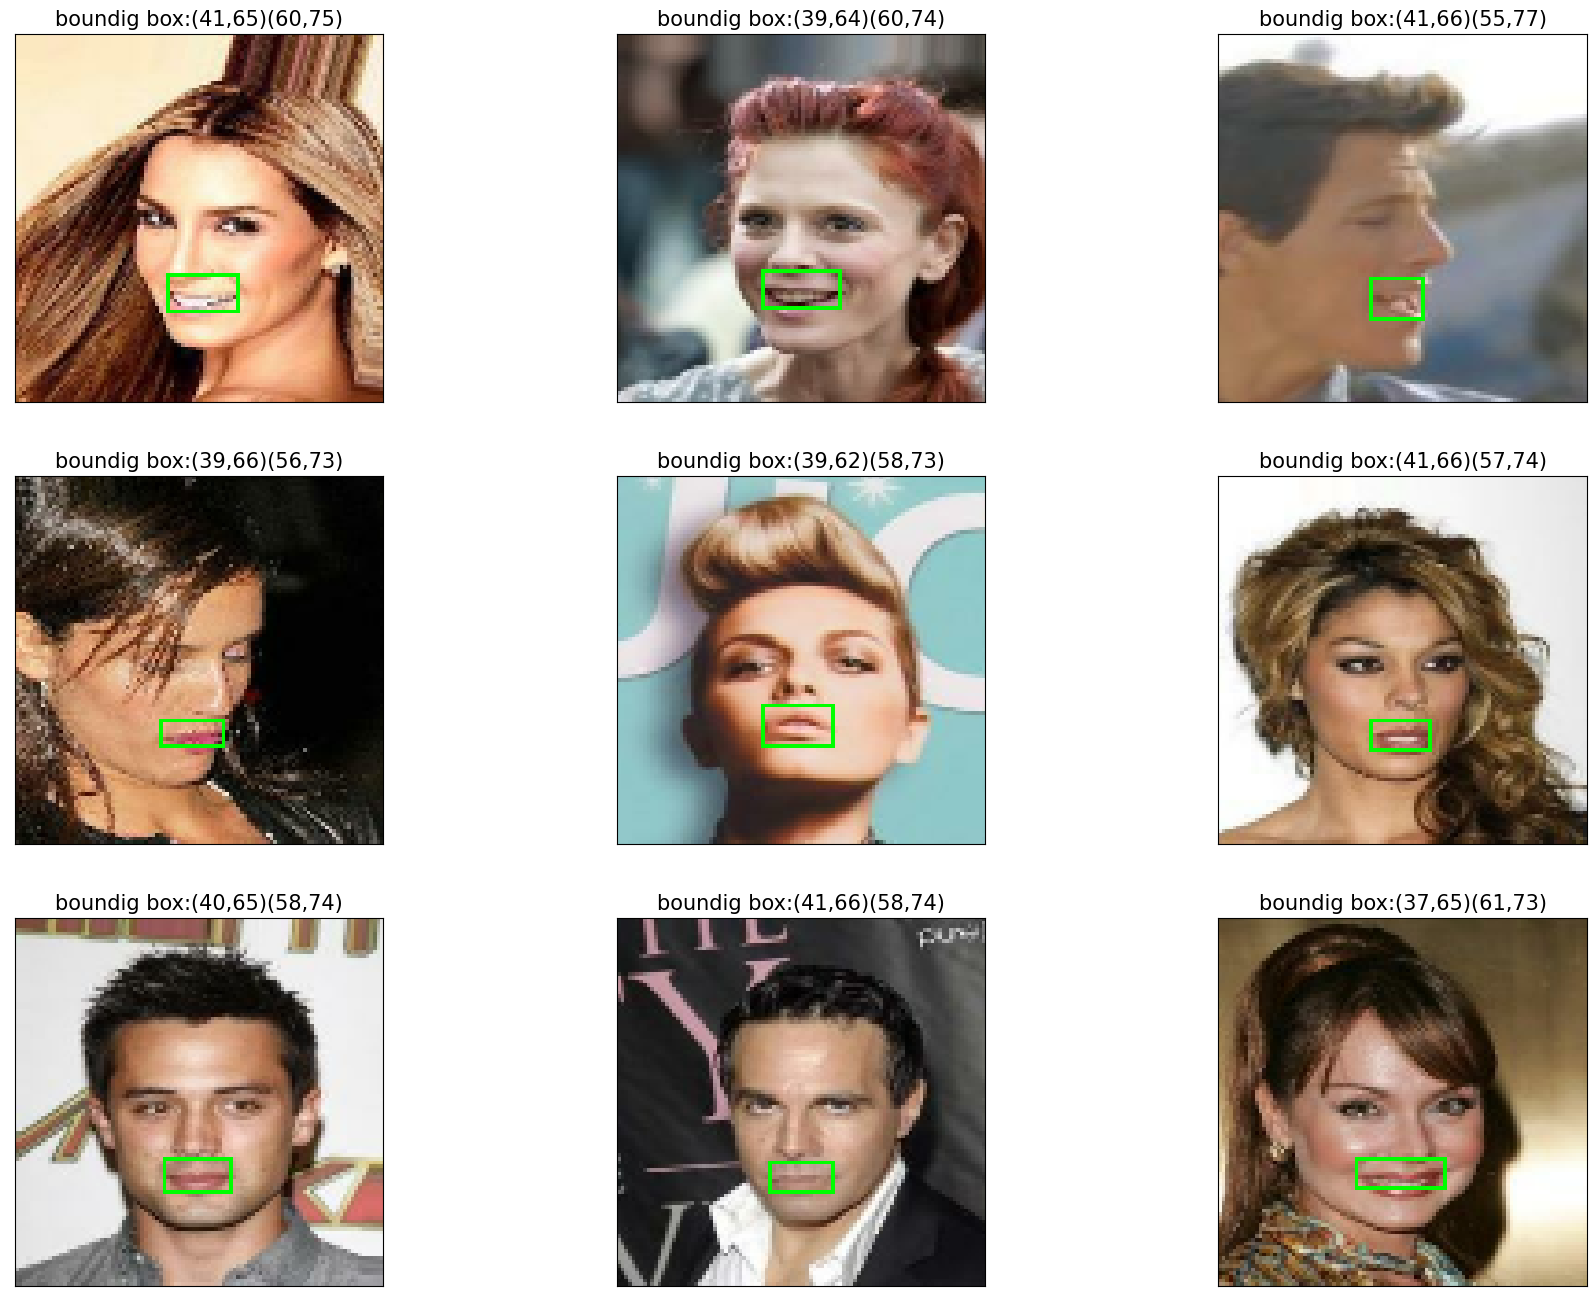

In [53]:
view_image_from_dataset(data, 9)


# Splitting dataset to 3 parts:
- train 80%
- validation 15% 
- test 5%

In [54]:
train_size = int(len(img_files) * 0.8)
val_size = int(len(img_files) * 0.15)
test_size = int(len(img_files) - (train_size + val_size))
train_size, val_size, test_size


(162079, 30389, 10131)

In [55]:
train_size + val_size + test_size, len(img_files)


(202599, 202599)

In [56]:
train = data.take(train_size)
val = data.skip(train_size)
val = val.take(val_size)
test = data.skip(train_size + val_size)


In [57]:
len(train), len(val), len(test)


(162079, 30389, 10131)

# Creating augmentation and normalization functions

In [58]:
def normalization(image, label):
    image_final = tf.image.convert_image_dtype(image, tf.float32) / 255
    return image_final, label


In [59]:
class_labels = np.zeros(
    1
)  # it's only needed for albuminations - this module needs some kind of label so we will give number 0
propability = 0.5
transform = A.Compose(
    [
        A.Rotate(limit=180, p=propability),
        A.RandomBrightnessContrast(p=propability),
        A.ImageCompression(quality_lower=85, quality_upper=100, p=propability),
        A.HueSaturationValue(
            hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=propability
        ),
        A.HorizontalFlip(p=propability),
        A.VerticalFlip(p=propability),
        A.ISONoise(p=propability),
        A.MotionBlur(p=propability),
        A.Perspective(p=propability),
        A.Affine(p=propability),
    ],
    bbox_params=A.BboxParams(
        format="albumentations", min_visibility=0.3, label_fields=["class_labels"]
    ),
)


In [60]:
def augmentation_normalization(img, label):
    transformed = transform(
        image=np.asarray(img, dtype=np.uint8),
        bboxes=[label.tolist()],
        class_labels=[class_labels],
    )
    aug_img = transformed["image"] / 255
    aug_bbox = transformed["bboxes"]

    return np.asarray(aug_img, dtype=np.float32), np.asarray(aug_bbox, dtype=np.float32)


def process_data(image, label):
    aug = tf.numpy_function(
        func=augmentation_normalization,
        inp=[image, label],
        Tout=(np.float32, np.float32),
    )
    return aug[0], aug[1]


def set_shapes(img, label):
    label.set_shape([4])
    return img, tf.squeeze(label)


# Preparing data with and without augmentation

In [61]:
train_augmented = train.map(process_data, num_parallel_calls=AUTOTUNE)
train_augmented = train_augmented.map(set_shapes, num_parallel_calls=AUTOTUNE)
train_augmented


<ParallelMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [62]:
train_no_aug = train.map(normalization, num_parallel_calls=AUTOTUNE)
train_no_aug


<ParallelMapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [63]:
val_augmented = val.map(process_data, num_parallel_calls=AUTOTUNE)
val_augmented = val_augmented.map(set_shapes, num_parallel_calls=AUTOTUNE)
val_augmented


<ParallelMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [64]:
val_no_aug = val.map(normalization, num_parallel_calls=AUTOTUNE)
val_no_aug


<ParallelMapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [65]:
test_augmented = test.map(process_data, num_parallel_calls=AUTOTUNE)
test_augmented = test_augmented.map(set_shapes, num_parallel_calls=AUTOTUNE)
test_augmented


<ParallelMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [66]:
test_no_aug = test.map(normalization, num_parallel_calls=AUTOTUNE)
test_no_aug


<ParallelMapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

## Let's take a look at augmented images

In [67]:
def view_augmented_image_from_dataset(ds, number_of_samples):
    fig = plt.figure(figsize=(22, 22))
    ds = ds.take(number_of_samples)
    for i, file in enumerate(ds):
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        img = cv2.rectangle(
            np.asarray(file[0] * 255),
            (int(file[1][0] * 100), int(file[1][1] * 100)),
            (int(file[1][2] * 100), int(file[1][3] * 100)),
            (0, 255, 0),
            1,
        )
        ax.set_title(
            f"boundig box:({int(file[1][0]*100)},{int(file[1][1]*100)})({int(file[1][2]*100)},{int(file[1][3]*100)})",
            fontsize=15,
        )
        ax.imshow(np.array(img, np.int32))


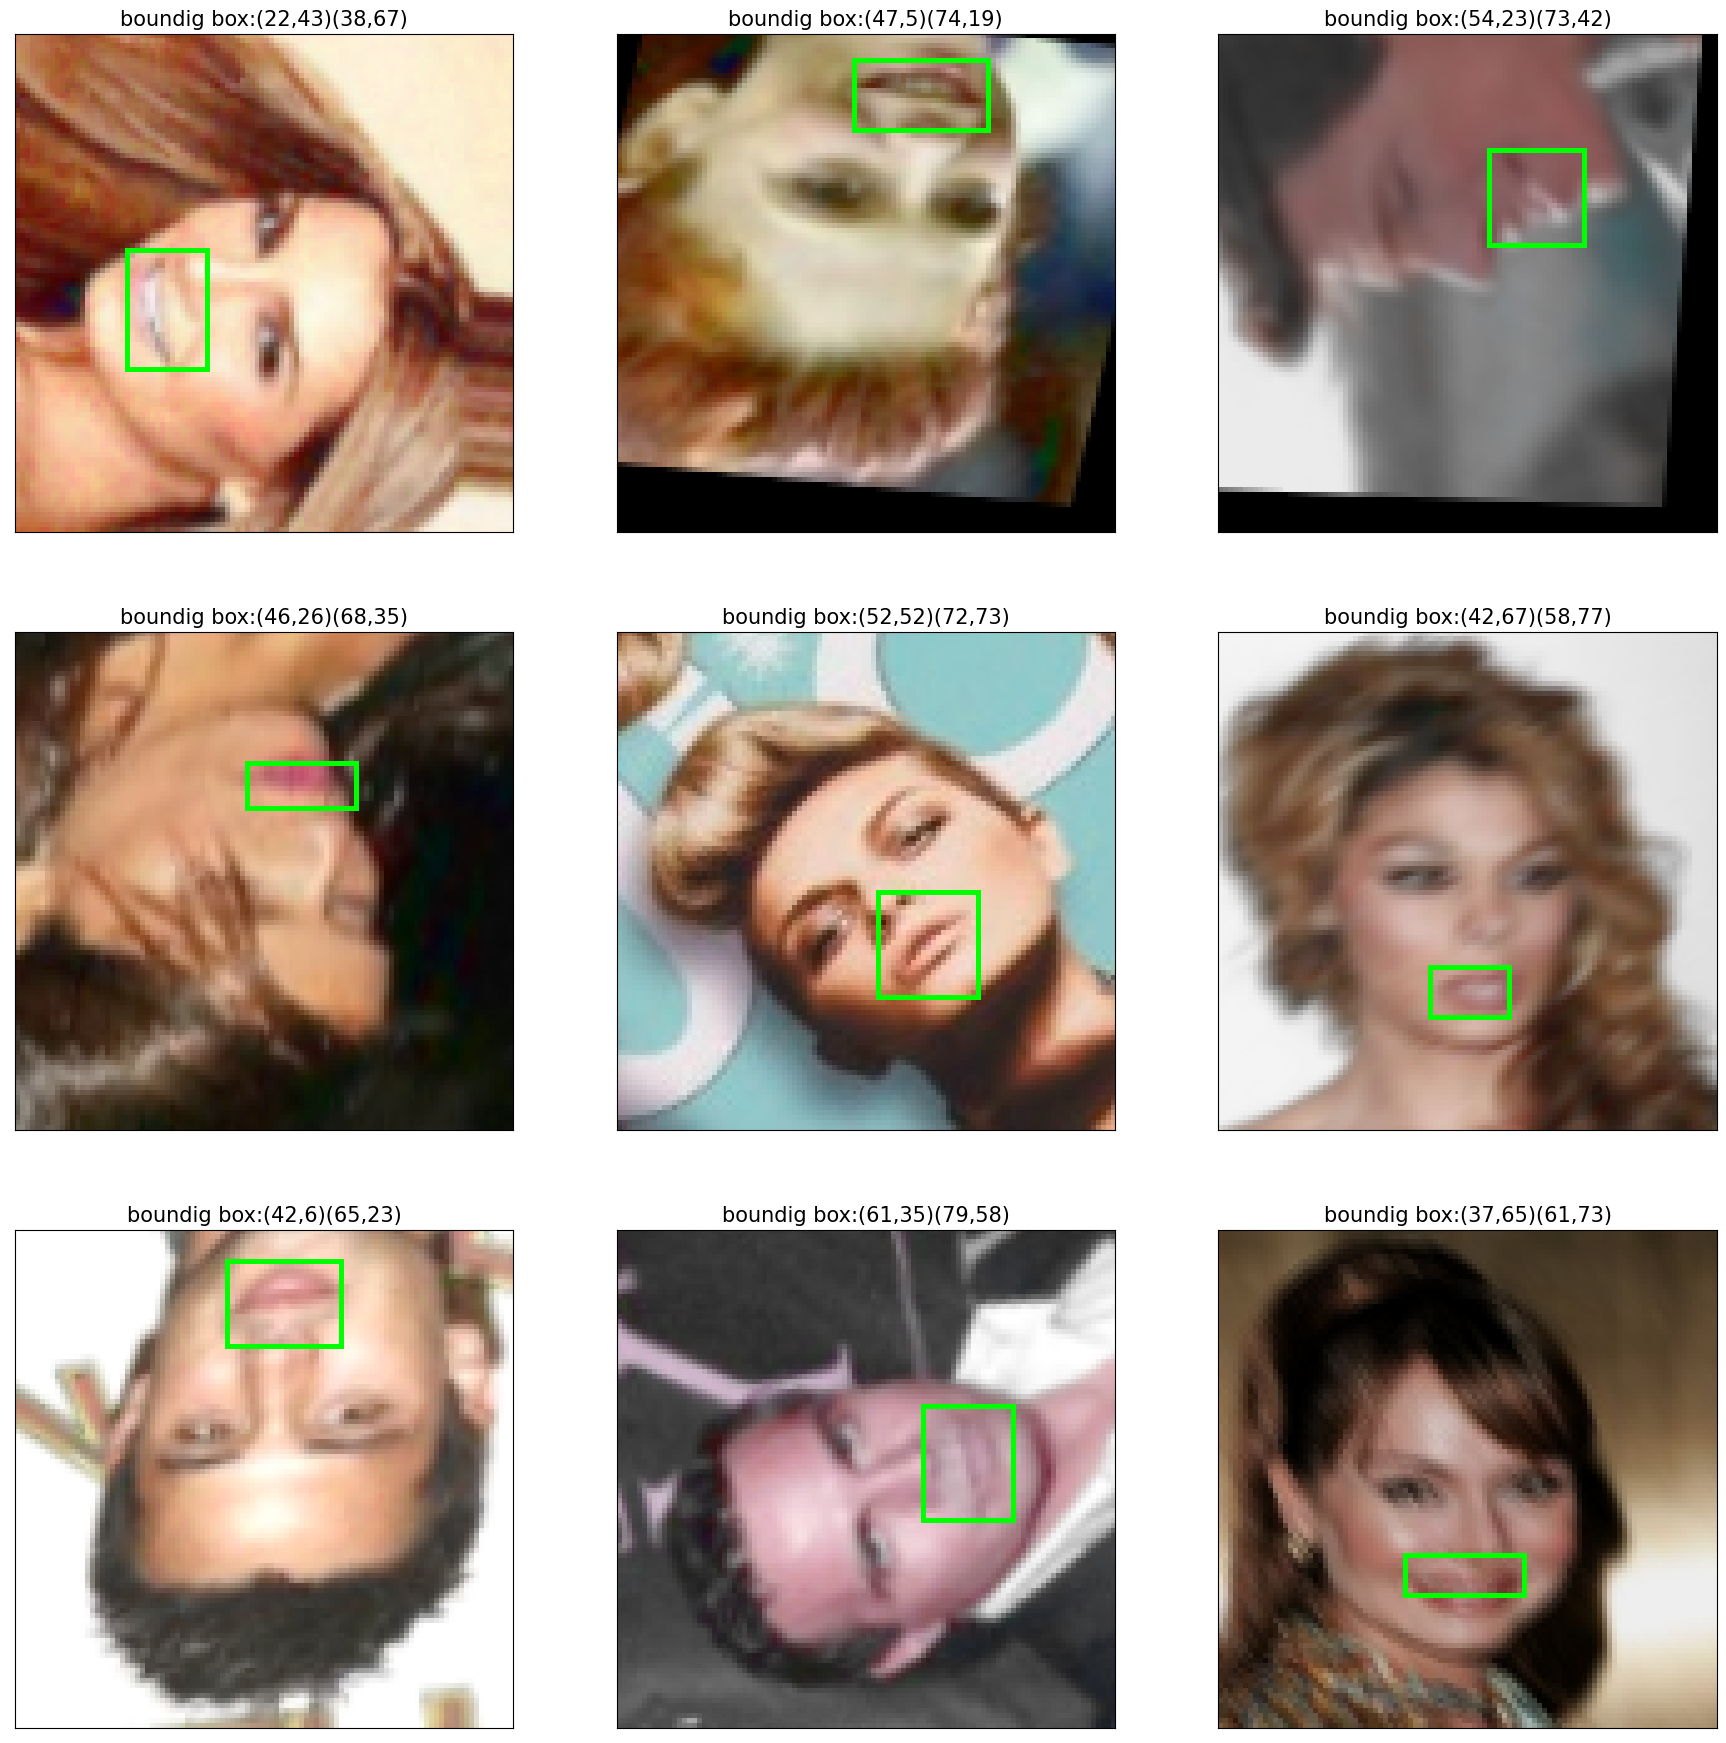

In [68]:
view_augmented_image_from_dataset(train_augmented, 9)


#  Batching data

In [69]:
train_no_aug = train_no_aug.batch(BATCH_SIZE).prefetch(2)
val_no_aug = val_no_aug.batch(BATCH_SIZE).prefetch(2)
test_no_aug = test_no_aug.batch(BATCH_SIZE).prefetch(2)


In [70]:
train_augmented = train_augmented.batch(BATCH_SIZE).prefetch(2)
val_augmented = val_augmented.batch(BATCH_SIZE).prefetch(2)
test_augmented = test_augmented.batch(BATCH_SIZE).prefetch(2)


# Creating models

## VGG16

In [71]:
vgg = VGG16(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
)
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

my_layers = Dense(128, activation="relu")(flatten)
my_layers = Dense(64, activation="relu")(my_layers)
my_layers = Dense(32, activation="relu")(my_layers)
my_layers = Dense(4, activation="linear")(my_layers)

model_vgg16 = Model(inputs=vgg.input, outputs=my_layers)
model_vgg16_no_augm = tf.keras.models.clone_model(model_vgg16)


In [72]:
model_vgg16.compile(loss="mse", optimizer="adam")
print(model_vgg16.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [73]:
model_vgg16_no_augm.compile(loss="mse", optimizer="adam")
print(model_vgg16_no_augm.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

## My own model

In [74]:
my_model = Sequential()

my_model.add(
    Conv2D(
        32,
        (3, 3),
        activation="relu",
        padding="same",
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    )
)
my_model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
my_model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
my_model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
my_model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
my_model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Flatten())
my_model.add(Dense(128, activation="relu"))
my_model.add(Dense(64, activation="relu"))
my_model.add(Dense(32, activation="relu"))
my_model.add(Dense(4, activation="linear"))
my_model_no_augm = tf.keras.models.clone_model(my_model)


In [75]:
my_model.compile(loss="mse", optimizer="adam")
print(my_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                    

In [76]:
my_model_no_augm.compile(loss="mse", optimizer="adam")
print(my_model_no_augm.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                    

## Training

### My model

In [ ]:
filepath = "models/my_model_augm.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
callbacks_list = [checkpoint, es]

my_model.fit(
    train_augmented,
    validation_data=(val_augmented),
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list,
)


In [ ]:
filepath = "models/my_model_no_augm.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
callbacks_list = [checkpoint, es]

my_model_no_augm.fit(
    train_no_aug,
    validation_data=(val_no_aug),
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list,
)


### VGG16

In [ ]:
filepath = "models/model_vgg16_augm.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
callbacks_list = [checkpoint, es]

model_vgg16.fit(
    train_augmented,
    validation_data=(val_augmented),
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list,
)


In [55]:
filepath = "models/model_vgg16_no_augm.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
callbacks_list = [checkpoint, es]


model_vgg16_no_augm.fit(
    train_no_aug,
    validation_data=(val_no_aug),
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list,
)


Epoch 1/100
634/634 [==============================] - ETA: 0s - loss: 0.0108
Epoch 1: val_loss improved from inf to 0.00019, saving model to models\model_vgg16_no_augm.h5
634/634 [==============================] - 186s 283ms/step - loss: 0.0108 - val_loss: 1.9048e-04
Epoch 2/100
633/634 [============================>.] - ETA: 0s - loss: 1.9298e-04
Epoch 2: val_loss improved from 0.00019 to 0.00019, saving model to models\model_vgg16_no_augm.h5
634/634 [==============================] - 198s 312ms/step - loss: 1.9299e-04 - val_loss: 1.8732e-04
Epoch 3/100
633/634 [============================>.] - ETA: 0s - loss: 1.9062e-04
Epoch 3: val_loss improved from 0.00019 to 0.00019, saving model to models\model_vgg16_no_augm.h5
634/634 [==============================] - 127s 200ms/step - loss: 1.9062e-04 - val_loss: 1.8504e-04
Epoch 4/100
633/634 [============================>.] - ETA: 0s - loss: 1.8739e-04
Epoch 4: val_loss improved from 0.00019 to 0.00018, saving model to models\model_vgg16_

# Loading saved models

In [77]:
my_model_no_augm = tf.keras.models.load_model("models/my_model_no_augm.h5")
my_model_augm = tf.keras.models.load_model("models/my_model_augm.h5")
model_vgg16_no_augm = tf.keras.models.load_model("models/model_vgg16_no_augm.h5")
model_vgg16_augm = tf.keras.models.load_model("models/model_vgg16_augm.h5")

models = [my_model_no_augm, my_model_augm, model_vgg16_no_augm, model_vgg16_augm]
test_data = [test_no_aug, test_augmented]

models_names = [
    "my_model_no_augm",
    "my_model_augm",
    "model_vgg16_no_augm",
    "model_vgg16_augm",
]
test_data_names = ["test_no_aug", "test_augmented"]


# Evaluating models

In [79]:
results = []
for i, m in enumerate(models):
    for j, t in enumerate(test_data):
        print(f"model: {models_names[i]}    test_data: {test_data_names[j]}")
        results.append(
            {
                "model": models_names[i],
                "test_data": test_data_names[j],
                "loss": m.evaluate(t),
            }
        )

df = pd.DataFrame.from_records(results)
df


model: my_model_no_augm    test_data: test_no_aug
40/40 [==============================] - 30s 40ms/step - loss: 1.7075e-05
model: my_model_no_augm    test_data: test_augmented
40/40 [==============================] - 46s 446ms/step - loss: 0.0473
model: my_model_augm    test_data: test_no_aug
40/40 [==============================] - 26s 39ms/step - loss: 9.7868e-05
model: my_model_augm    test_data: test_augmented
40/40 [==============================] - 45s 437ms/step - loss: 4.8085e-04
model: model_vgg16_no_augm    test_data: test_no_aug
40/40 [==============================] - 31s 138ms/step - loss: 9.0242e-05
model: model_vgg16_no_augm    test_data: test_augmented
40/40 [==============================] - 47s 441ms/step - loss: 0.0475
model: model_vgg16_augm    test_data: test_no_aug
40/40 [==============================] - 32s 111ms/step - loss: 6.4867e-04
model: model_vgg16_augm    test_data: test_augmented
40/40 [==============================] - 45s 437ms/step - loss: 0.0024


model       test_data      loss
0     my_model_no_augm     test_no_aug  0.000017
1     my_model_no_augm  test_augmented  0.047341
2        my_model_augm     test_no_aug  0.000098
3        my_model_augm  test_augmented  0.000481
4  model_vgg16_no_augm     test_no_aug  0.000090
5  model_vgg16_no_augm  test_augmented  0.047504
6     model_vgg16_augm     test_no_aug  0.000649
7     model_vgg16_augm  test_augmented  0.002362

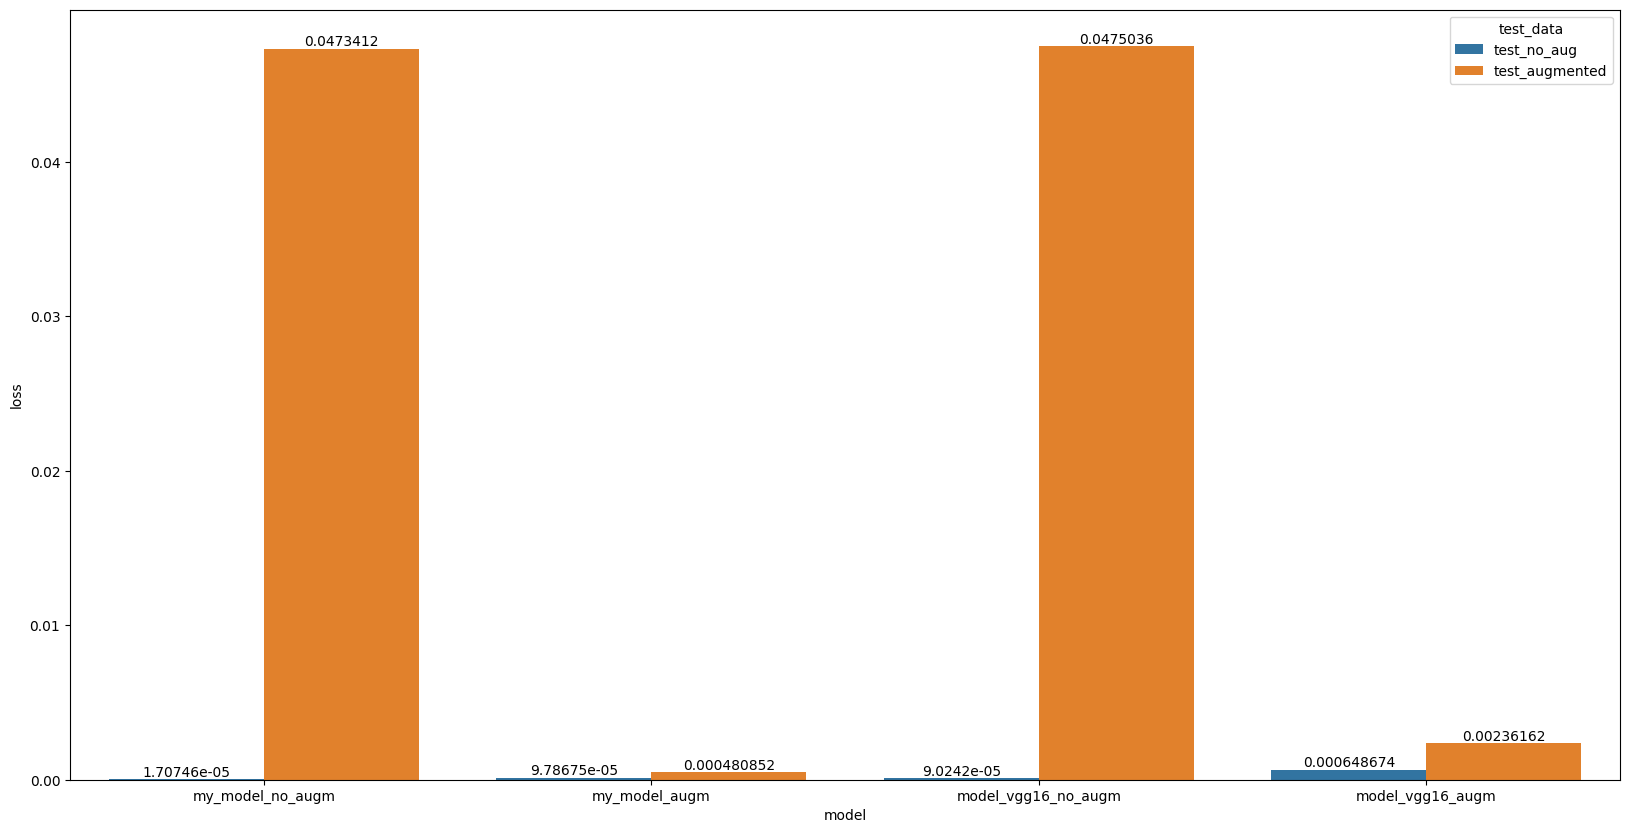

In [80]:
fig = plt.figure(figsize=(20, 10))
ax = sns.barplot(x="model", y="loss", hue="test_data", data=df)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()


# Let's have a look at models predictions.

In [81]:
def draw_bb(preds, img, color=(0, 255, 0)):
    preds = [x * 100 for x in preds]
    x_min, y_min, x_max, y_max = preds
    img_bb = cv2.rectangle(
        np.asarray(img), (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, 1
    )
    return img_bb


In [82]:
image_aug, label_aug = next(iter(test_augmented))
image_no_aug, label_no_aug = next(iter(test_no_aug))


def view_test_pred(model, image, label, num_model):
    image = image.numpy()
    label = label.numpy()
    preds = model.predict(image)
    fig = plt.figure(figsize=(22, 22))

    for i in range(4):
        ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
        img = image[i]
        img = draw_bb(label[i], img, color=(0, 255, 0))
        img = draw_bb(preds[i], img, color=(255, 0, 0))
        ax.set_title(f"{models_names[num_model]}", fontsize=15)
        plt.imshow((img))


## Model trained on non-augmented images - predictions

8/8 [==============================] - 1s 5ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8/8 [==============================] - 0s 6ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


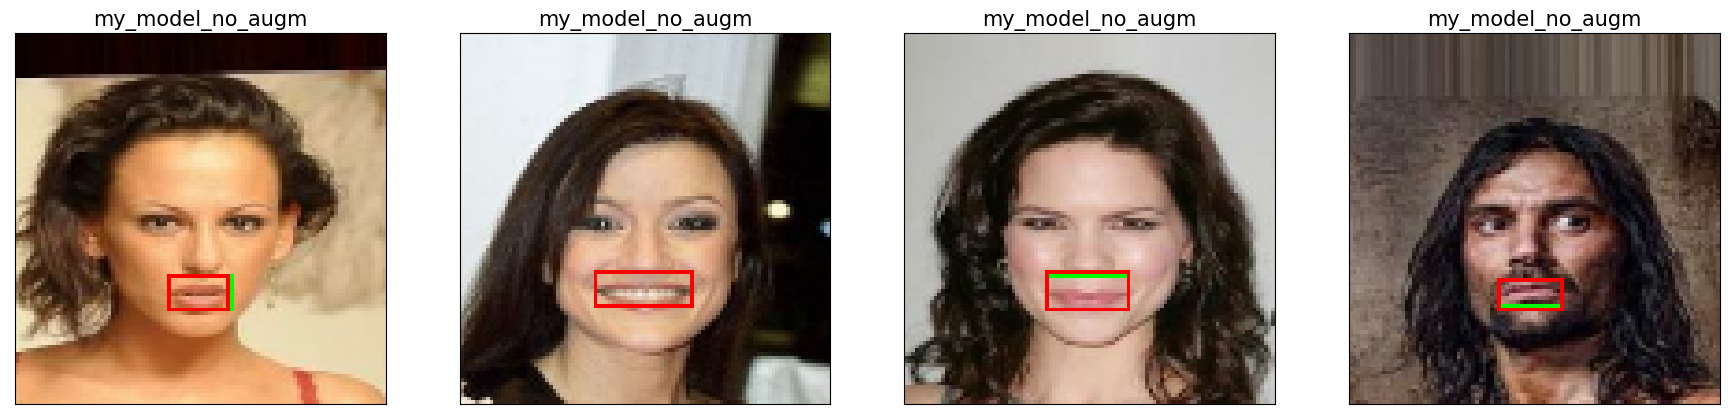

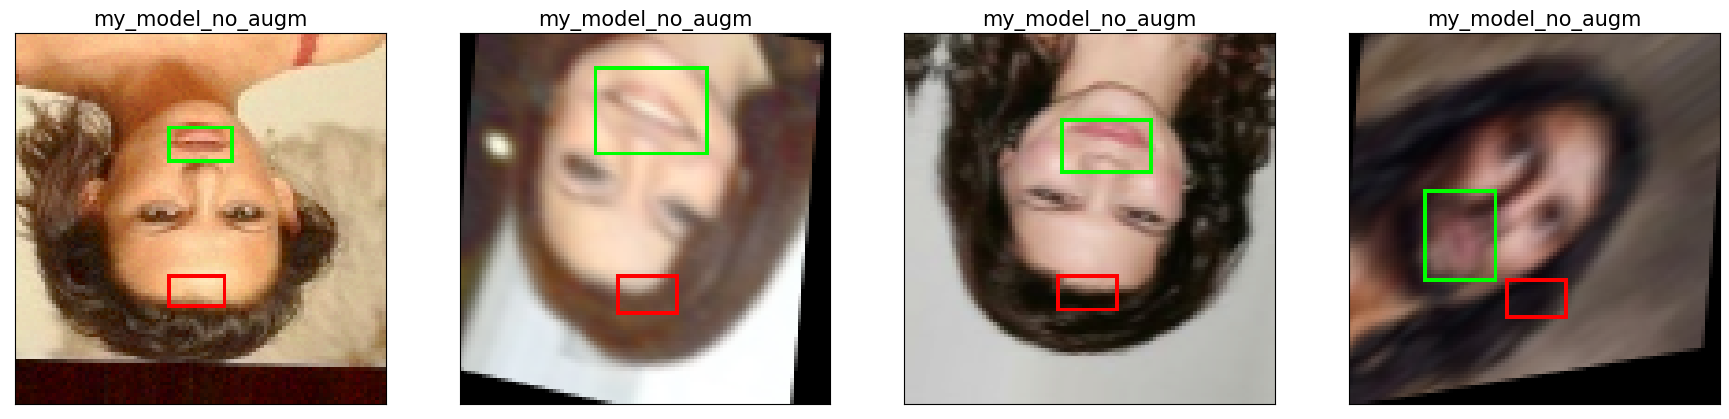

In [83]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[0], num_model=0)
view_test_pred(image=image_aug, label=label_aug, model=models[0], num_model=0)


## Model trained on augmented images - predictions

8/8 [==============================] - 0s 6ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8/8 [==============================] - 0s 6ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


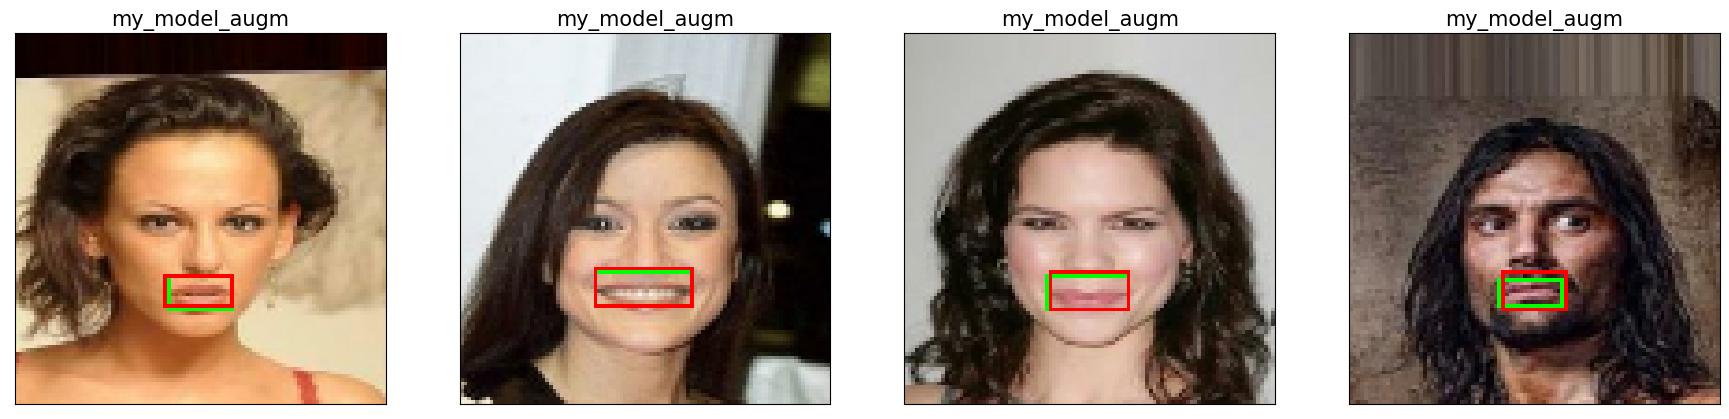

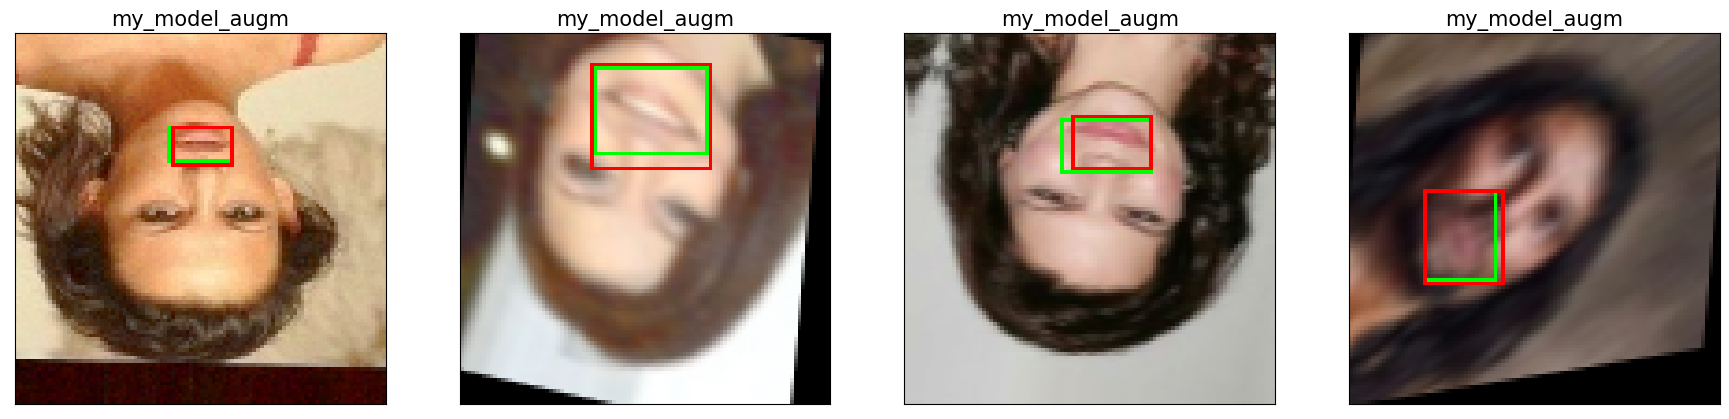

In [84]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[1], num_model=1)
view_test_pred(image=image_aug, label=label_aug, model=models[1], num_model=1)


## VGG16 model trained on non-augmented images - predictions

8/8 [==============================] - 1s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8/8 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


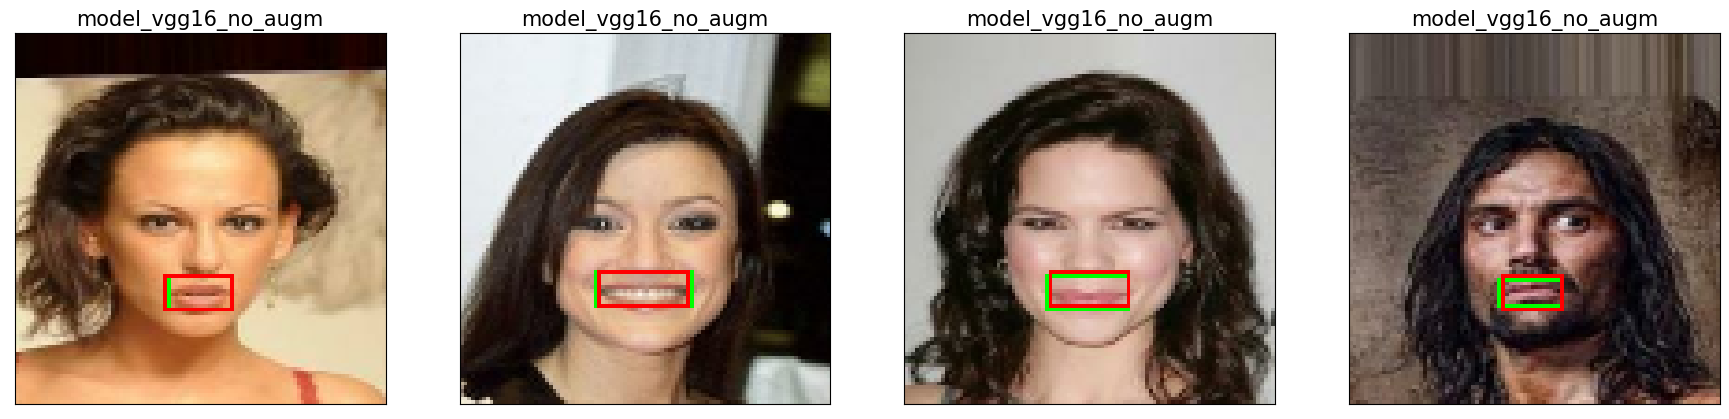

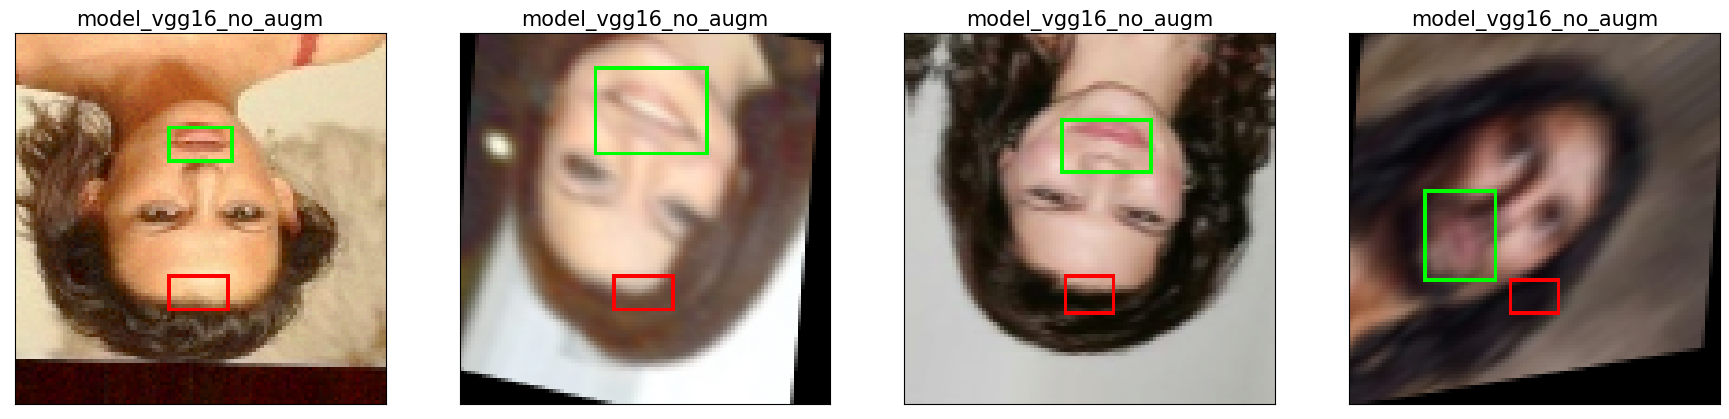

In [85]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[2], num_model=2)
view_test_pred(image=image_aug, label=label_aug, model=models[2], num_model=2)


## VGG16 model trained on augmented images - predictions

8/8 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8/8 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


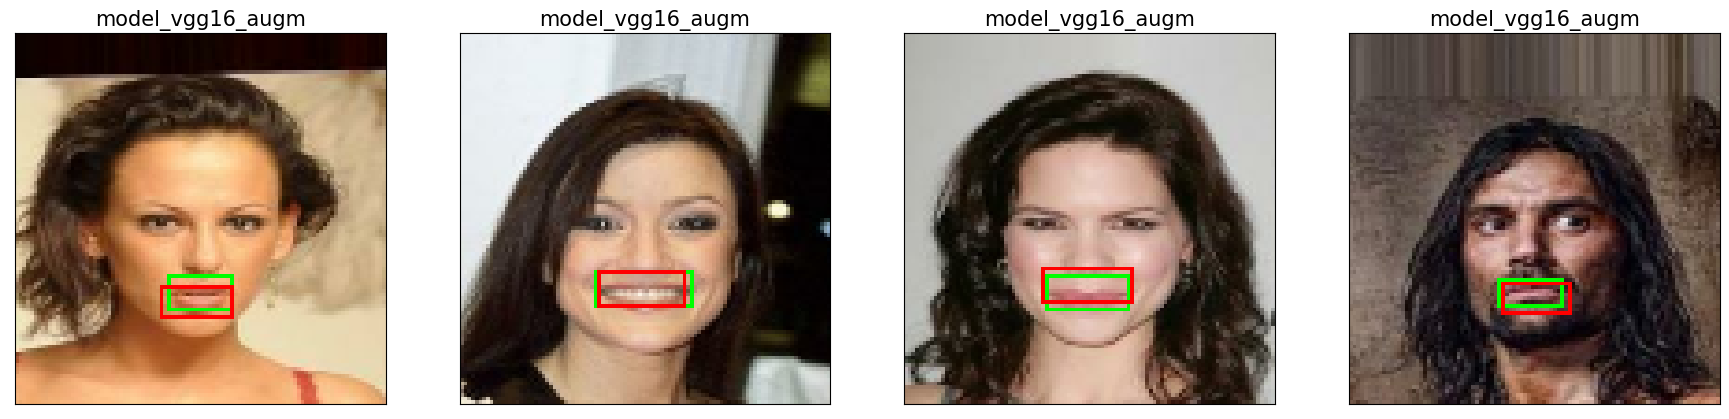

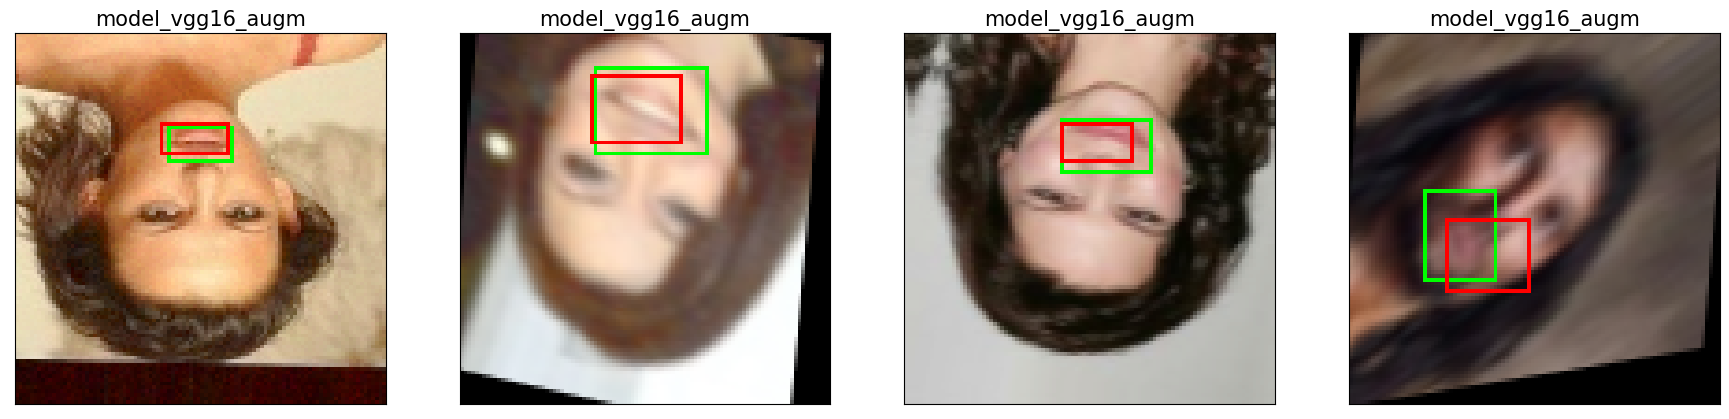

In [86]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[3], num_model=3)
view_test_pred(image=image_aug, label=label_aug, model=models[3], num_model=3)


# Predictions on my images

In [87]:
my_img_dir = "my_img/test/."
l = len(os.listdir(my_img_dir))
temp_bb = [-1, -1, 2, 2]
temp_bb = [temp_bb for i in range(l)]
my_images = tf.keras.utils.image_dataset_from_directory(
    "my_img",
    batch_size=64,
    image_size=(target_height, target_width),
    labels=temp_bb,
    shuffle=False,
)
print(my_images)


Found 4 files belonging to 1 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.int32, name=None))>


In [88]:
my_images = my_images.map(normalization)
image, label = next(iter(my_images))


1/1 [==============================] - 0s 220ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 94ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 306ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 104ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


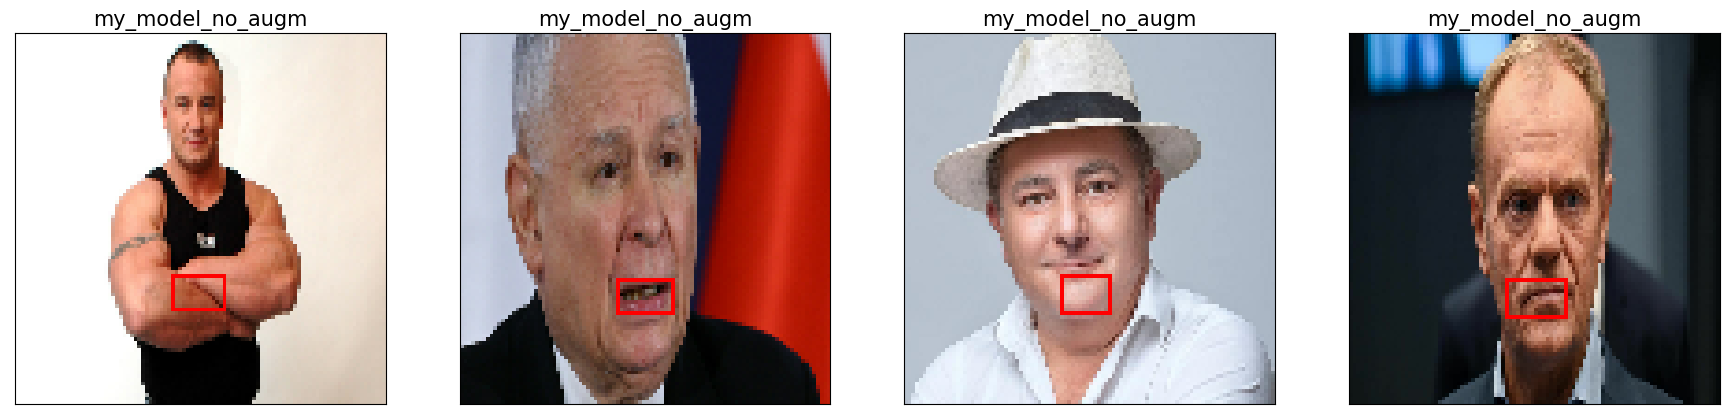

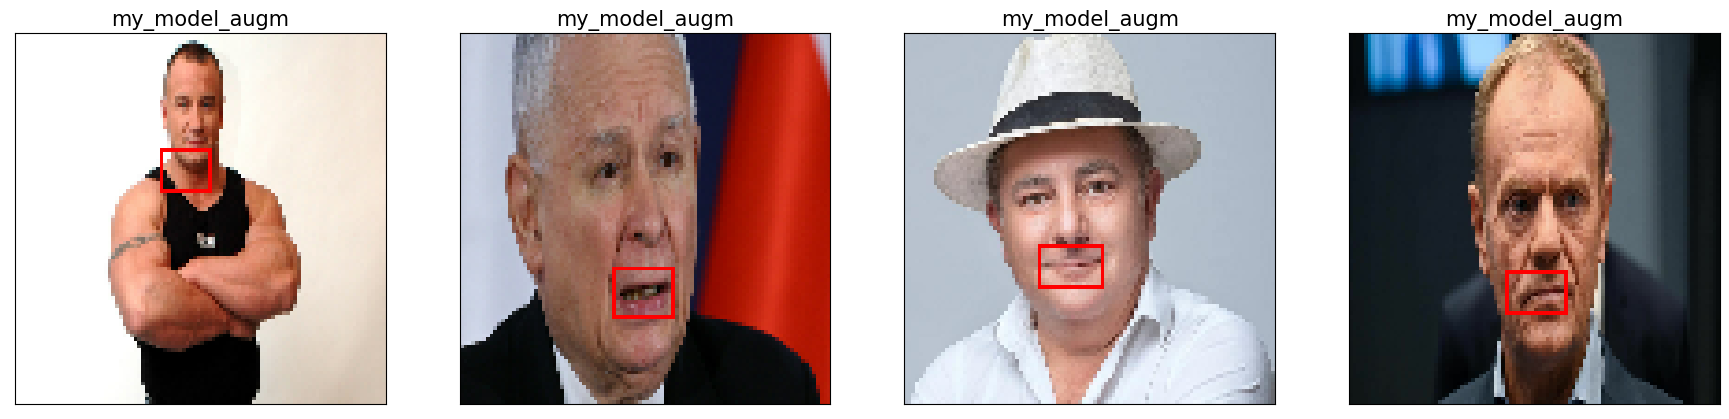

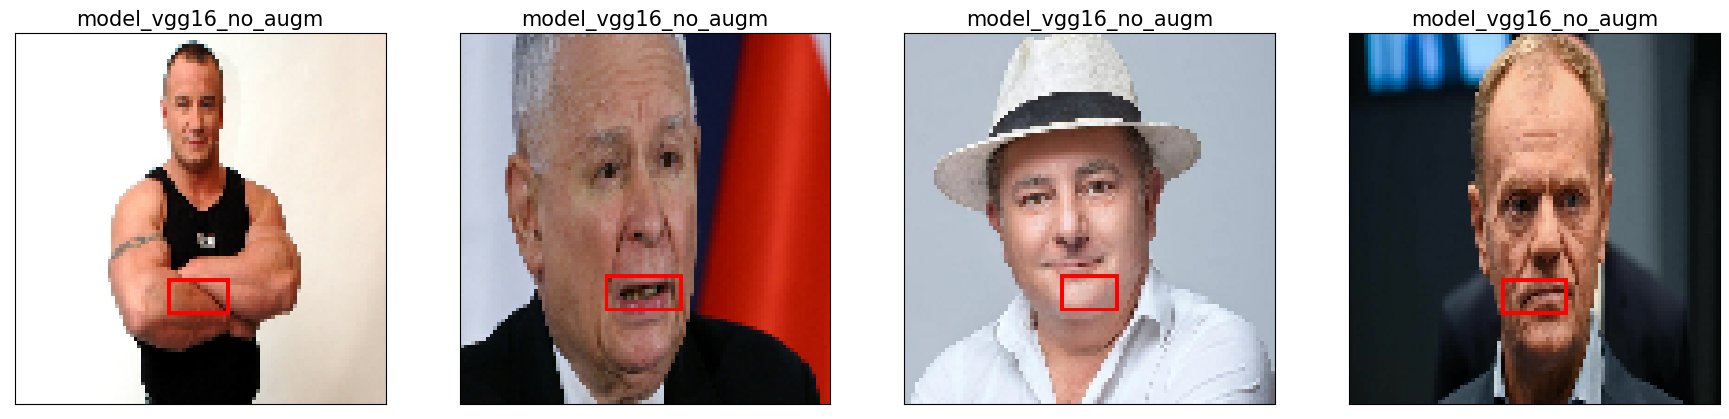

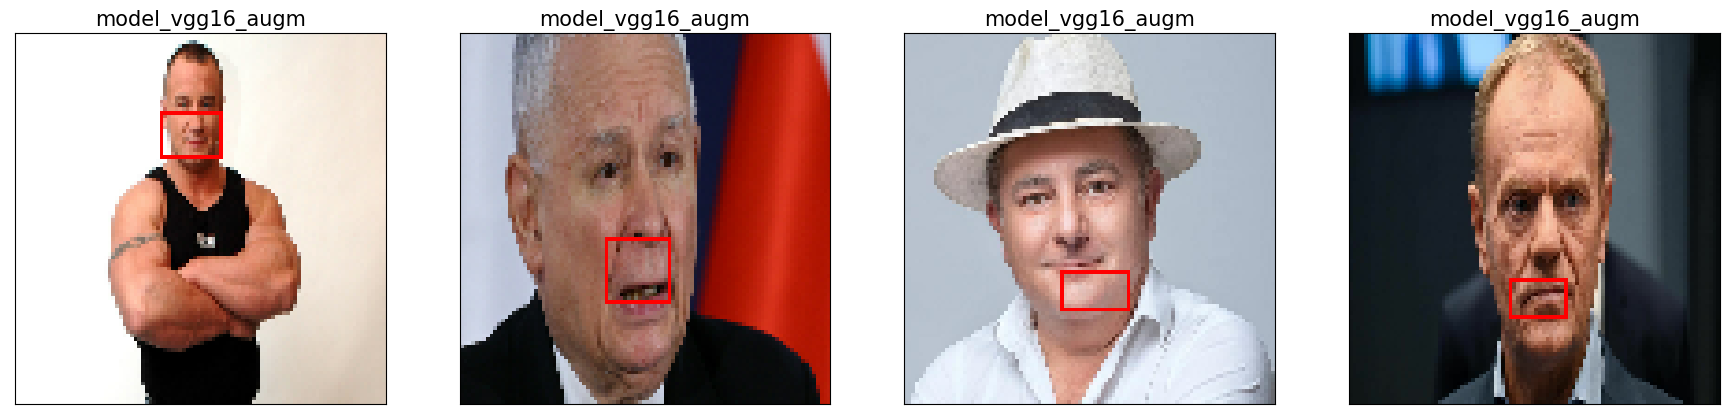

In [89]:
import warnings

warnings.filterwarnings("ignore")
for i, m in enumerate(models):
    view_test_pred(model=m, image=image, label=label, num_model=i)
